- GridSearchCV를 통한 SVD 하이퍼파라미터 튜닝
- 영화의 장르 정보를 활용한 콘텐츠 기반 유사도 계산을 결합한 하이브리드 추천 시스템

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 병합

In [2]:
ratings_path = '../data/ml-100k/u.data'
movies_path = '../data/ml-100k/u.item'

ratings_df = pd.read_csv(ratings_path, sep='\t',
                         names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_columns = ['item_id', 'title', 'release_data', 'vide_release_date', 'IMDb_URL',
                  'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv(movies_path, sep='|', names=movies_columns, encoding='latin-1')

merged_df = pd.merge(ratings_df, movies_df, on='item_id')

# 2. EDA: 영화별 평점 통계와 장르별 평점 분석

상위 인기 영화:
                          title      mean  count
1398           Star Wars (1977)  4.358491    583
333              Contact (1997)  3.803536    509
498                Fargo (1996)  4.155512    508
1234  Return of the Jedi (1983)  4.007890    507
860            Liar Liar (1997)  3.156701    485

장르별 평균 평점:
          genre    rating
0        Action  3.480245
1     Adventure  3.503527
2     Animation  3.576699
3      Children  3.353244
4        Comedy  3.394073
5         Crime  3.632278
6   Documentary  3.672823
7         Drama  3.687379
8       Fantasy  3.215237
9     Film-Noir  3.921523
10       Horror  3.290389
11      Musical  3.521397
12      Mystery  3.638132
13      Romance  3.621705
14       Sci-Fi  3.560723
15     Thriller  3.509007
16          War  3.815812
17      Western  3.613269
18      unknown  3.200000


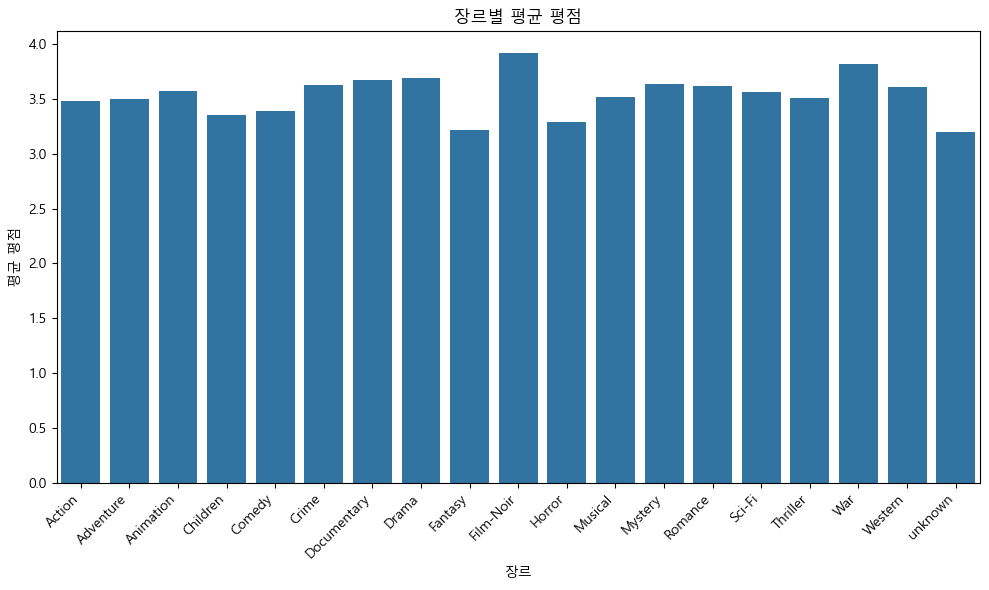

In [4]:
movie_stats = merged_df.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.sort_values(by='count', ascending=False)
print("상위 인기 영화:")
print(movie_stats.head())

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_ratings = merged_df.melt(id_vars=['user_id', 'item_id', 'rating', 'timestamp', 'title'],
                               value_vars=genre_columns, var_name='genre', value_name='is_genre')
genre_ratings = genre_ratings[genre_ratings['is_genre'] == 1]
genre_stats = genre_ratings.groupby('genre')['rating'].mean().reset_index()
print('\n장르별 평균 평점:')
print(genre_stats)

plt.figure(figsize=(10, 6))
sns.barplot(x='genre', y='rating', data=genre_stats)
plt.xticks(rotation=45, ha='right')
plt.title('장르별 평균 평점')
plt.xlabel('장르')
plt.ylabel('평균 평점')
plt.tight_layout()
plt.show()

# 3. 협업 필터링 모델: SVD 하이퍼파라미터 튜닝

In [6]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)
best_params = gs.best_params['rmse']
print("\n최적의 SVD 하이퍼파라미터:", best_params)
print("최적의 CV RMSE:", gs.best_score['rmse'])

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
best_algo = SVD(n_factors=best_params['n_factors'],
                n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'],
                reg_all=best_params['reg_all'],
                random_state=42)
best_algo.fit(trainset)
predictions = best_algo.test(testset)
rmse_value = accuracy.rmse(predictions)


최적의 SVD 하이퍼파라미터: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
최적의 CV RMSE: 0.9334350281434199
RMSE: 0.9246


# 4. 콘텐츠 기반 필터링: 영화 장르 정보를 활용한 유사도 계산

In [10]:
movie_genres = movies_df[['item_id'] + genre_columns].copy()
genre_matrix = movie_genres[genre_columns].values
similarity_matrix = cosine_similarity(genre_matrix)

# 5. 하이브리드 추천 함수: 협업 필터링과 콘텐츠 기반 유사도 결합

In [12]:
def get_hybrid_recommendations(user_id, n=5):
    """
    사용자에게 협업 필터링과 콘텐츠 기반 필터링을 결합한 하이브리드 추천을 제공
    """
    # 사용자가 평가한 영화 ID 모록
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].unique()
    all_movies = movies_df['item_id'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
    
    recommendations = []
    for movie_id in unrated_movies:
        # 협업 필터링 예측 평점
        cf_pred = best_algo.predict(user_id, movie_id).est
        
        # 콘텐츠 기반 평점: 사용자가 높게 평가한 영화들과의 평균 유사도 계산 (평점 >= 4)
        user_high_rated = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
        content_score = 0
        if not user_high_rated.empty:
            similarities = []
            idx_current = movies_df[movies_df['item_id'] == movie_id].index[0]
            for r_movie in user_high_rated['item_id']:
                idx_rated = movies_df[movies_df['item_id'] == r_movie].index[0]
                similarities.append(similarity_matrix[idx_current, idx_rated])
            content_score = np.mean(similarities)
            
        # 두 점수를 결합 (가중치: 협업 필터링 70%, 콘텐츠 기반 30%)
        # 콘텐츠 유사도는 0~1 범위이므로 5점 척도로 변환하여 결합
        combined_score = 0.7 * cf_pred + 0.3 * (content_score * 5)
        recommendations.append((movie_id, combined_score))
        
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_n_idx = [rec[0] for rec in recommendations[:n]]
    top_n_movies = movies_df[movies_df['item_id'].isin(top_n_idx)][['item_id', 'title']]
    return top_n_movies

# 6. 사용자 1에 대한 하이브리드 추천 결과 출력

In [13]:
user_id_example = 1
hybrid_recommendations = get_hybrid_recommendations(user_id_example, n=5)
print(f"\n사용자 {user_id_example}에 대한 하이브리드 추천 영화 Top 5:")
print(hybrid_recommendations)


사용자 1에 대한 하이브리드 추천 영화 Top 5:
     item_id                                   title
284      285                   Secrets & Lies (1996)
315      316               As Good As It Gets (1997)
356      357  One Flew Over the Cuckoo's Nest (1975)
482      483                       Casablanca (1942)
511      512                  Wings of Desire (1987)


- **결과 해석:**
    - 인기 영화와 장르별 평점 분석 결과는 이전 프로젝트와 유사하게 데이터의 분포를 잘 반영하고 있습니다.
    - 최적의 SVD 하이퍼파라미터를 도출하고 RMSE가 약 0.9246로 개선된 점은 모델 성능 측면에서 긍정적입니다.
    - 사용자 1에게 제공된 추천 결과는 기존 협업 필터링 방식과 달리 콘텐츠 정보를 추가함으로써 다양한 영화(예: *Secrets & Lies*, *As Good As It Gets*, *Casablanca* 등)를 추천하여 추천의 폭을 넓혔음을 보여줍니다.